In [1]:
from collections import deque, namedtuple
import os
from snnUtils import *
from IPython.display import clear_output

from tqdm import tqdm
import pandas as pd
import random, imageio, time, copy
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

In [2]:
# Define the super parameters
projectName = "snnRL"

# Save/Get weights from presistent storage. Pass empty string for not saving. 
# Pass derive for using google derive (If code is running in colab). If local, 
# pass the location of your desire
savePath = "./Data"
backUpNetworks = False 
saveLen = 30 # Number of latest checkpoints to save

# Handle save path
if savePath != None:
    if savePath == "derive":
        # Mount gdrive if we want to interact with cloab
        from google.colab import drive
        drive.mount('/content/gdrive')
        savePath = "gdrive/MyDrive/Colab Notebooks/Data/"
    backUpNetworks = True

# Making the environment
env = gym.make("LunarLander-v3") # Use render_mode = "human" to render each episode
state, info = env.reset() # Get a sample state of the environment
stateSize = env.observation_space.shape # Number of variables to define current step
nActions = env.action_space.n # Number of actions
nObs = len(state) # Number of features


# Set pytorch parameters: The device (CPU or GPU) and data types
__device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
__dtype = torch.float

In [3]:
class qNetwork_SNN(nn.Module):
    def __init__(self, inputSize, L1Size, L2Size, L3Size, L4Size, outputSize, **kwargs):
        super().__init__()

        # Model super parameters
        self.beta = kwargs["beta"]
        self.tSteps = kwargs["tSteps"]

        # Defining the layers
        self.layer1 = nn.Linear(inputSize, L1Size)
        self.L1LIF = snn.Leaky(beta = self.beta)
        self.layer2 = nn.Linear(L1Size, L2Size)
        self.L2LIF = snn.Leaky(beta = self.beta)
        self.layer3 = nn.Linear(L2Size, L3Size)
        self.L3LIF = snn.Leaky(beta = self.beta)
        self.layer4 = nn.Linear(L3Size, L4Size)
        self.L4LIF = snn.Leaky(beta = self.beta)
        self.output = nn.Linear(L4Size, outputSize)
        self.outputLIF = snn.Leaky(beta = self.beta)


    def forward(self, x):

        # Set initial potentials to be zero
        potential1 = self.L1LIF.reset_mem()
        potential2 = self.L2LIF.reset_mem()
        potential3 = self.L3LIF.reset_mem()
        potential4 = self.L4LIF.reset_mem()
        potential5 = self.outputLIF.reset_mem()

        # Save the state of the output layer
        outSpikes = []
        outPotentials = []

        # Iterate through time steps
        for t in range(self.tSteps):
            # First layer
            current1 = self.layer1(x)
            spk1, potential1 = self.L1LIF(current1, potential1)

            # Second layer
            current2 = self.layer2(spk1)
            spk2, potential2 = self.L2LIF(current2, potential2)

            # Third layer
            current3 = self.layer3(spk2)
            spk3, potential3 = self.L3LIF(current3, potential3)

            # Fourth layer
            current4 = self.layer4(spk3)
            spk4, potential4 = self.L4LIF(current4, potential4)

            #Output
            current5 = self.output(spk4)
            spk5, potential5 = self.outputLIF(current5, potential5)

            # Save output
            outSpikes.append(spk5)
            outPotentials.append(potential5)

        return torch.stack(outSpikes, dim = 0).sum(dim = 0)

# Model parameters
nL1, nL2, nL3, nL4 = 256, 128, 64, 32
learningRate = .0001
timeSteps = 25
snnBeta = .95
eDecay = 0.999
modelDetails = f"{nL1}_{nL2}_{nL3}_{nL4}_{learningRate}_{timeSteps}_{snnBeta}_{eDecay}"

# Make the model objects
qNetwork_model = qNetwork_SNN(stateSize[0], nL1, nL2, nL3, nL4, nActions, beta = snnBeta, tSteps = timeSteps).to(__device, dtype = __dtype)
targetQNetwork_model = qNetwork_SNN(stateSize[0], nL1, nL2, nL3, nL4, nActions, beta = snnBeta, tSteps = timeSteps).to(__device, dtype = __dtype)

# Two models should have identical weights initially
targetQNetwork_model.load_state_dict(qNetwork_model.state_dict())

# TODO: Add gradient clipping to the optimizer for avoiding exploding gradients
# Suitable optimizer for gradient descent
optimizer_main = torch.optim.Adam(qNetwork_model.parameters(), lr=learningRate)
optimizer_target = torch.optim.Adam(targetQNetwork_model.parameters(), lr=learningRate)

# Starting episode and ebsilon
startEpisode = 0
startEbsilon = None
lstHistory = None

# If given access to drive, try to load the latest saved weights
qNetworkSaveHistory = deque(maxlen = saveLen)
targetQNetworkSaveHistory = deque(maxlen = saveLen)
if backUpNetworks:
    if os.path.isdir(savePath):
        _lst = os.listdir(savePath)
        for _file in _lst:
            if f"{projectName}_{modelDetails}_qNetwork_model.pth" == _file:
                qNetworkSaveHistory = torch.load(os.path.join(savePath, _file))
                _chekcPoint = qNetworkSaveHistory[0] # Take the most recent chekcpoint
                qNetwork_model.load_state_dict(_chekcPoint["model_state_dict"]) # Model weights
                optimizer_main.load_state_dict(_chekcPoint["optimizer_state_dict"]) # Optimizer
                startEpisode = int(_chekcPoint["episode"]) # Starting episode number
                startEbsilon = float(_chekcPoint["hyperparameters"]["ebsilon"]) # Starting ebsilon
                lstHistory = _chekcPoint["train_history"]
                eDecay = _chekcPoint["hyperparameters"]["eDecay"] if "eDecay" in _chekcPoint["hyperparameters"].keys() else None

                print(f"Loaded Q-network weights for episode {startEpisode}")

            if f"{projectName}_{modelDetails}_targetQNetwork_model.pth" == _file:
                targetQNetworkSaveHistory = torch.load(os.path.join(savePath, _file))
                _chekcPoint = targetQNetworkSaveHistory[0] # Take the most recent chekcpoint
                targetQNetwork_model.load_state_dict(_chekcPoint["model_state_dict"]) # Model weights

                print(f"Loaded Target Q-network weights for episode {int(_chekcPoint['episode'])}")
    else:
          print("Save path doesn't exist. Making it.")
          os.makedirs(savePath)

beginning_qNetwork = [qNetwork_model.layer1.weight, qNetwork_model.layer2.weight, qNetwork_model.output.weight]
beginning_targeQNetwork = [targetQNetwork_model.layer1.weight, targetQNetwork_model.layer2.weight, targetQNetwork_model.output.weight]

Loaded Q-network weights for episode 2
Loaded Target Q-network weights for episode 2


C:\Users\Spino.shop\AppData\Local\Temp\ipykernel_3016\4260664721.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qNetworkSaveHistory = torch.load(os.path.join(savePath,

In [4]:
print(f"Device is: {__device}")

# Start the timer
tstart = time.time()

# The experience of the agent is saved as a named tuple containing various variables
agentExp = namedtuple("exp", ["state", "action", "reward", "nextState", "done"])

# Parameters
nEpisodes = 6000 # Number of learning episodes
maxNumTimeSteps = 1000 # The number of time step in each episode
gamma = .995 # The discount factor
ebsilon = 1 if startEbsilon == None else startEbsilon # The starting  value of ebsilon
ebsilonEnd   = .1 # The finishing value of ebsilon
eDecay = eDecay # The rate at which ebsilon decays
miniBatchSize = 100 # The length of minibatch that is used for training
memorySize = 100_000 # The length of the entire memory
numUpdateTS = 4 # Frequency of time steps to update the NNs
numP_Average = 100 # The number of previous episodes for calculating the average episode reward

# Variables for saving the required data for later analysis
episodePointHist = [] # For saving each episode's point for later demonstration
episodeTimeHist = [] # For saving the time it took for episode to end
actionString = "" # A string containing consecutive actions taken in an episode (dellimited by comma, i.e. 1,2,4,2,1 etc.)
episodeHistDf = None
lstHistory = [{"episode": None,"seed": None,"points": None,"timesteps": None,"duration": None}] if lstHistory == None else lstHistory
initialCond = None # initial condition (state) of the episode
epPointAvg = -999999
latestChekpoint = 0

# Making the memory buffer object
mem = ReplayMemory(memorySize, __dtype, __device)

for episode in range(startEpisode, nEpisodes):
    initialSeed = random.randint(1,1_000_000_000) # The random seed that determines the episode's I.C.
    state, info = env.reset(seed = initialSeed)
    points = 0
    actionString = ""
    initialCond = state

    tempTime = time.time()
    _lastPrinttime = tempTime # For printing the training progress 
    for t in range(maxNumTimeSteps):

        qValueForActions = qNetwork_model(torch.tensor(state, device = __device, dtype = __dtype))

        # use ebsilon-Greedy algorithm to take the new step
        action = getAction(qValueForActions, ebsilon)

        # Take a step
        observation, reward, terminated, truncated, info = env.step(action)

        # Store the experience of the current step in an experience deque.
        mem.addNew(
            agentExp(
                state, # Current state
                action,
                reward, # Current state's reward
                observation, # Next state
                True if terminated or truncated else False
            )
        )

        # Check to see if we have to update the networks in the current step
        update = updateNetworks(t, mem, miniBatchSize, numUpdateTS)

        if update:
            initial_weights = {name: param.clone() for name, param in qNetwork_model.named_parameters()}
            # Update the NNs
            experience = mem.sample(miniBatchSize)

            # Update the Q-Network and the target Q-Network
            # Bear in mind that we do not update the target Q-network with direct gradient descent.
            # so there is no optimizer needed for it
            fitQNetworks(experience, gamma, [qNetwork_model, optimizer_main], [targetQNetwork_model, None])

        # Save the necessary data
        points += reward
        state = observation.copy()
        actionString += f"{action},"

        # Print the training status. Print only once each second to avoid jitters.
        if 1 < (time.time() - _lastPrinttime):
            # clear_output(wait=True)
            # _lastPrinttime = time.time()
            # print(f"ElapsedTime: {int(time.time() - tstart): <5}s | Episode: {episode: <5} | Timestep: {t: <5} | The average of the {numP_Average: <5} episodes is: {int(epPointAvg): <5}")
            # print(f"Latest chekpoint: {latestChekpoint} | Speed {t/(time.time()-tempTime):.1f} tps | ebsilon: {ebsilon:.3f}")
            pass
            
            # fig= plt.figure(figsize=(12,6))
            # plt.plot(pd.DataFrame(lstHistory)["episode"], pd.DataFrame(lstHistory)["points"])
            # plt.show()

        # Handle episode ending
        if terminated or truncated:
            # Save the episode history in dataframe
            if (episode+1) % 3 == 0:
                # only save every 10 episodes
                lstHistory.append({
                    "episode": episode,
                    "seed": initialSeed,
                    "points": points,
                    "timesteps": t,
                    "duration": time.time() - tempTime
                })
                
            break

    # Saving the current episode's points and time
    episodePointHist.append(points)
    episodeTimeHist.append(time.time()-tempTime)

    # Getting the average of {numP_Average} episodes
    epPointAvg = np.mean(episodePointHist[-numP_Average:])

    # Decay ebsilon
    ebsilon = decayEbsilon(ebsilon, eDecay, ebsilonEnd)

    # Save model weights and parameters periodically (For later use)
    if backUpNetworks:
        if (episode + 1) % 3 == 0:
            _chekcPoint = {
                "episode": episode,
                'model_state_dict': qNetwork_model.state_dict(),
                'optimizer_state_dict': optimizer_main.state_dict(),
                'hyperparameters': {"ebsilon": ebsilon, "eDecay":eDecay},
                "train_history": lstHistory
            }
            qNetworkSaveHistory.appendleft(_chekcPoint)
            torch.save(qNetworkSaveHistory, os.path.join(savePath, f"{projectName}_{modelDetails}_qNetwork_model.pth"))

            _chekcPoint = {
                "episode": episode,
                'model_state_dict': targetQNetwork_model.state_dict(),
                'optimizer_state_dict': optimizer_target.state_dict(),
                'hyperparameters': {"ebsilon": ebsilon, "eDecay":eDecay},
                "train_history": lstHistory
            }
            targetQNetworkSaveHistory.appendleft(_chekcPoint)
            torch.save(targetQNetworkSaveHistory, os.path.join(savePath, f"{projectName}_{modelDetails}_targetQNetwork_model.pth"))

            # Save the episode number
            latestChekpoint = episode

    # Stop the learning process if suitable average point is reacheds
    if 50 < epPointAvg:
        Tend = time.time()
        print(f"\nThe learning ended. Elapsed time for learning: {Tend-tstart}s")
        break

# Reset the index
episodeHistDf = pd.DataFrame(lstHistory)
episodeHistDf.reset_index(drop=True, inplace=True)

env.close()

Device is: cuda
tensor([[0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 1.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 1.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2.],
        [0., 2., 2., 2

KeyboardInterrupt: 

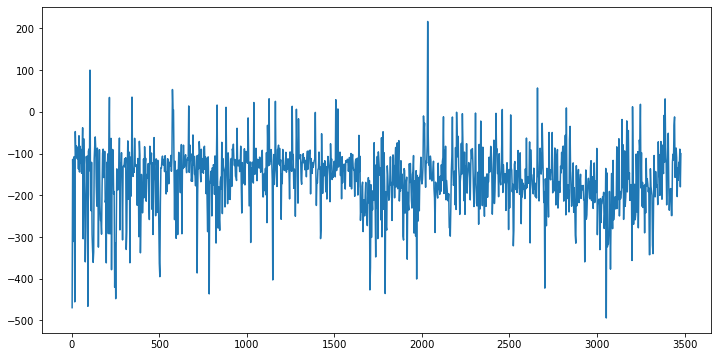

In [ ]:
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(lstHistory)["episode"], pd.DataFrame(lstHistory)["points"])


In [ ]:
class qNetwork_SNN(nn.Module):
    def __init__(self, inputSize, L1Size, L2Size, L3Size, L4Size, outputSize, **kwargs):
        super().__init__()

        # Model super parameters
        self.beta = kwargs["beta"]
        self.tSteps = kwargs["tSteps"]

        # Defining the layers
        self.layer1 = nn.Linear(inputSize, L1Size)
        self.L1LIF = snn.Leaky(beta = self.beta)
        self.layer2 = nn.Linear(L1Size, L2Size)
        self.L2LIF = snn.Leaky(beta = self.beta)
        self.layer3 = nn.Linear(L2Size, L3Size)
        self.L3LIF = snn.Leaky(beta = self.beta)
        self.layer4 = nn.Linear(L3Size, L4Size)
        self.L4LIF = snn.Leaky(beta = self.beta)
        self.output = nn.Linear(L4Size, outputSize)
        self.outputLIF = snn.Leaky(beta = self.beta)


    def forward(self, x):

        # Set initial potentials to be zero
        potential1 = self.L1LIF.reset_mem()
        potential2 = self.L2LIF.reset_mem()
        potential3 = self.L3LIF.reset_mem()
        potential4 = self.L4LIF.reset_mem()
        potential5 = self.outputLIF.reset_mem()

        # Save the state of the output layer
        L1_Spikes = []
        L1_Potentials = []
        L2_Spikes = []
        L2_Potentials = []
        L3_Spikes = []
        L3_Potentials = []
        L4_Spikes = []
        L4_Potentials = []
        outSpikes = []
        outPotentials = []

        # Iterate through time steps
        for t in range(self.tSteps):
            # First layer
            current1 = self.layer1(x)
            spk1, potential1 = self.L1LIF(current1, potential1)

            # Second layer
            current2 = self.layer2(spk1)
            spk2, potential2 = self.L2LIF(current2, potential2)

            # Third layer
            current3 = self.layer3(spk2)
            spk3, potential3 = self.L3LIF(current3, potential3)

            # Fourth layer
            current4 = self.layer4(spk3)
            spk4, potential4 = self.L4LIF(current4, potential4)

            #Output
            current5 = self.output(spk4)
            spk5, potential5 = self.outputLIF(current5, potential5)

            # Save output
            L1_Spikes.append(spk1)
            L1_Potentials.append(potential1)
            L2_Spikes.append(spk2)
            L2_Potentials.append(potential2)
            L3_Spikes.append(spk3)
            L3_Potentials.append(potential3)
            L4_Spikes.append(spk4)
            L4_Potentials.append(potential4)
            outSpikes.append(spk5)
            outPotentials.append(potential5)

        returnDict = {
            "L1_spikes": torch.stack(L1_Spikes, dim = 0),
            "L1_potentials": torch.stack(L1_Potentials, dim = 0),
            "L2_spikes": torch.stack(L2_Spikes, dim = 0),
            "L2_potentials": torch.stack(L2_Potentials, dim = 0),
            "L3_spikes": torch.stack(L3_Spikes, dim = 0),
            "L3_potentials": torch.stack(L3_Potentials, dim = 0),
            "L4_spikes": torch.stack(L4_Spikes, dim = 0),
            "L4_potentials": torch.stack(L4_Potentials, dim = 0),
            "out_spikes": torch.stack(outSpikes, dim = 0),
            "out_potentials": torch.stack(outPotentials, dim = 0),
            
        }
        
        return returnDict

tempNetwork = qNetwork_SNN(stateSize[0], nL1, nL2, nL3, nL4, nActions, beta = snnBeta, tSteps = timeSteps).to(__device, dtype = __dtype)
tempNetwork.load_state_dict(qNetwork_model.state_dict())

<All keys matched successfully>

In [ ]:
seed = random.randint(0, 1_000_000_000)
environment = gym.make("LunarLander-v3", render_mode = "human")

lstActions = []
lstStates = []
state, _ = environment.reset(seed = seed)
points = 0

maxStepN = 1000
for t in range(maxStepN):
    # Take greedy steps
    # action = np.argmax(qNetwork_model(np.expand_dims(state, axis = 0)))
    

    action = torch.argmax(qNetwork_model(torch.tensor(state, device = __device, dtype = __dtype)))

    state, reward, terminated, truncated, _ = environment.step(action.item())
    lstActions.append(action)
    lstStates.append(state)
    
    if terminated or truncated:
        break


In [ ]:
_d["L1_potentials"][:,1].shape

torch.Size([25])

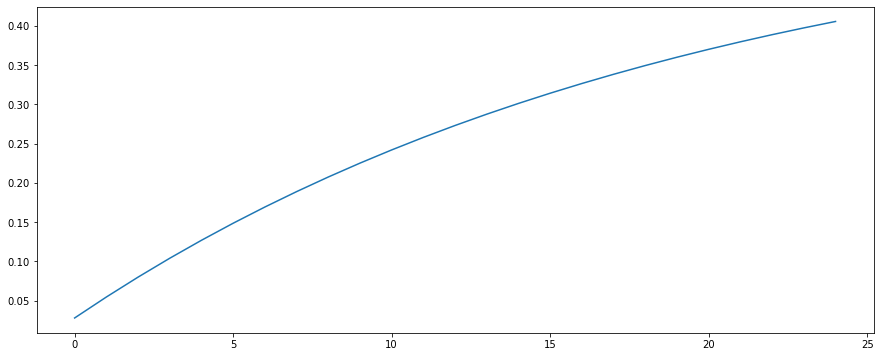

In [ ]:
_d = tempNetwork(torch.tensor(lstStates[0], device = __device, dtype = __dtype))
_d["L1_potentials"]

fig = plt.figure(figsize=(15,6))
plt.plot(_d["L1_potentials"][:,8].cpu().detach().numpy())

In [ ]:
tempNetwork(torch.tensor(state, device = __device, dtype = __dtype))

tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SumBackward1>)

In [ ]:
for i in range(len(lstStates[0])):
    print(f"min: {pd.DataFrame(lstStates)[i].min():.4f} | max: {pd.DataFrame(lstStates)[i].max():.4f}")

min: 0.0106 | max: 0.3123
min: -0.0421 | max: 1.4021
min: 0.3751 | max: 0.7766
min: -1.7330 | max: -0.2085
min: -0.0230 | max: 0.2237
min: -5.2157 | max: 0.2248
min: 0.0000 | max: 0.0000
min: 0.0000 | max: 1.0000


In [ ]:
print(lstActions[0])
print(lstStates[0])
tempNetwork(torch.tensor(lstStates[0], device = __device, dtype = __dtype)).sum(dim = 0)

tensor(0, device='cuda:0')
[ 0.01059942  1.4021168   0.5360555  -0.20848754 -0.01214245 -0.12017634
  0.          0.        ]


tensor(13., device='cuda:0', grad_fn=<SumBackward1>)

Model Architecture:
------------------
qNetwork_SNN(
  (layer1): Linear(in_features=8, out_features=256, bias=True)
  (L1LIF): Leaky()
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (L2LIF): Leaky()
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (L3LIF): Leaky()
  (layer4): Linear(in_features=64, out_features=32, bias=True)
  (L4LIF): Leaky()
  (output): Linear(in_features=32, out_features=4, bias=True)
  (outputLIF): Leaky()
)

Parameter Shapes:
----------------
layer1.weight: torch.Size([256, 8])
layer1.bias: torch.Size([256])
layer2.weight: torch.Size([128, 256])
layer2.bias: torch.Size([128])
layer3.weight: torch.Size([64, 128])
layer3.bias: torch.Size([64])
layer4.weight: torch.Size([32, 64])
layer4.bias: torch.Size([32])
output.weight: torch.Size([4, 32])
output.bias: torch.Size([4])

Total Parameters: 45,668


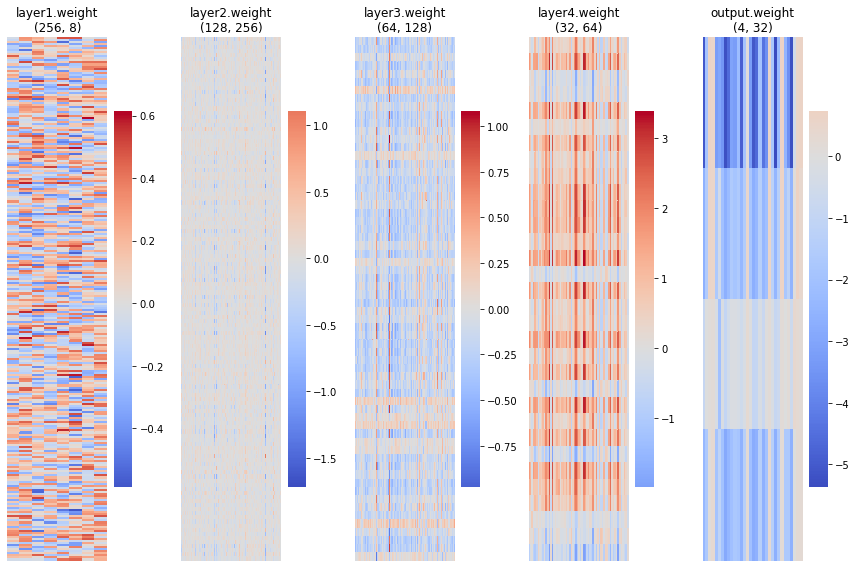

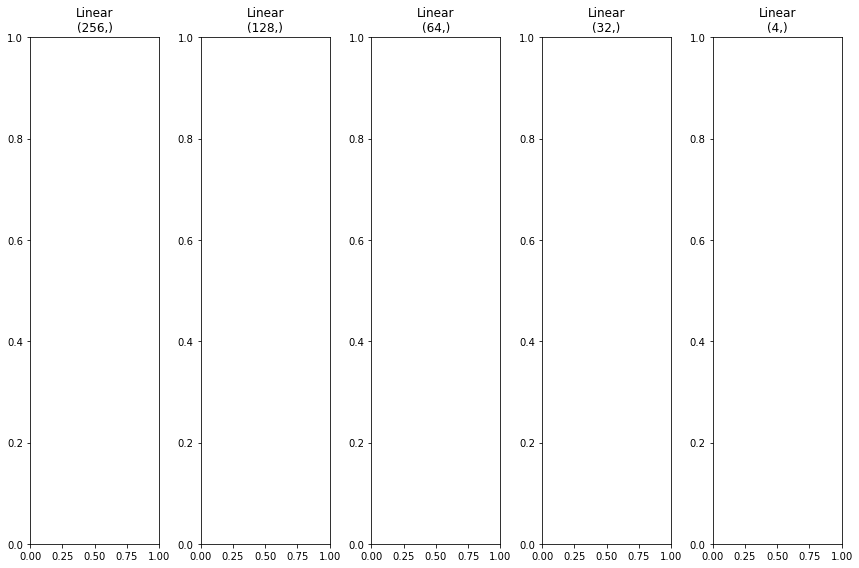

In [ ]:
import seaborn as sns
class NNVisualizer:
    def __init__(self, model):
        """
        Initialize the visualizer with a PyTorch model
        """
        self.model = model
        
    def plot_weights(self, figsize=(12, 8)):
        """
        Plot heatmaps of weights for each layer
        """
        plt.figure(figsize=figsize)
        plots = 1
        
        # Count number of layers with weights
        num_layers = sum(1 for name, param in self.model.named_parameters() if 'weight' in name)
        
        for name, param in self.model.named_parameters():
            if 'weight' in name:
                plt.subplot(1, num_layers, plots)
                weight_matrix = param.detach().cpu().numpy()
                
                # For 2D weights (fully connected layers)
                if len(weight_matrix.shape) == 2:
                    sns.heatmap(weight_matrix, cmap='coolwarm', center=0,
                            xticklabels=False, yticklabels=False)
                    plt.title(f'{name}\n{weight_matrix.shape}')
                
                # For 4D weights (convolutional layers)
                elif len(weight_matrix.shape) == 4:
                    # Reshape to 2D for visualization
                    reshaped = weight_matrix.reshape(weight_matrix.shape[0], -1)
                    sns.heatmap(reshaped, cmap='coolwarm', center=0,
                            xticklabels=False, yticklabels=False)
                    plt.title(f'{name}\n{weight_matrix.shape}')
                
                plots += 1
        
        plt.tight_layout()
        plt.show()
    
    def plot_activations(self, input_tensor, figsize=(12, 8)):
        """
        Plot activations for each layer given an input
        """
        activations = {}
        
        # Hook to capture activations
        def hook_fn(module, input, output):
            activations[module] = output.detach()
        
        # Register hooks for all layers
        hooks = []
        for name, module in self.model.named_modules():
            if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.ReLU)):
                hooks.append(module.register_forward_hook(hook_fn))
        
        # Forward pass
        self.model.eval()
        with torch.no_grad():
            _ = self.model(input_tensor)
        
        # Plot activations
        plt.figure(figsize=figsize)
        plots = 1
        
        for module, activation in activations.items():
            plt.subplot(1, len(activations), plots)
            
            # Get activation data
            act_data = activation.cpu().numpy()
            
            # For 2D activations
            if len(act_data.shape) == 2:
                sns.heatmap(act_data, cmap='viridis',
                        xticklabels=False, yticklabels=False)
            # For 4D activations (conv layers)
            elif len(act_data.shape) == 4:
                # Show first channel's activation
                sns.heatmap(act_data[0, 0], cmap='viridis',
                        xticklabels=False, yticklabels=False)
            
            plt.title(f'{module.__class__.__name__}\n{act_data.shape}')
            plots += 1
        
        plt.tight_layout()
        plt.show()
        
        # Remove hooks
        for hook in hooks:
            hook.remove()

    def print_model_summary(self):
        """
        Print a summary of the model architecture and parameters
        """
        print("Model Architecture:")
        print("------------------")
        print(self.model)
        print("\nParameter Shapes:")
        print("----------------")
        for name, param in self.model.named_parameters():
            print(f"{name}: {param.shape}")
        
        total_params = sum(p.numel() for p in self.model.parameters())
        print(f"\nTotal Parameters: {total_params:,}")
        
visualizer = NNVisualizer(qNetwork_model)

# View model summary
visualizer.print_model_summary()

# Plot weights
visualizer.plot_weights()

# Plot activations for a sample input
sample_input = torch.randn(1, 8)  # Adjust size based on your model
visualizer.plot_activations(torch.tensor(lstStates[0], device = __device, dtype = __dtype))

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

# Authenticate
gauth = GoogleAuth()
gauth.LocalWebserverAuth()  # Follow the prompts to authenticate
drive = GoogleDrive(gauth)

InvalidConfigError: Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)